# CNN features

In [240]:
!git clone -b dev https://github.com/Finweto/Projet-deep-learning-2022.git

fatal: destination path 'Projet-deep-learning-2022' already exists and is not an empty directory.


### Imports

In [241]:
import itertools
import os
import pathlib
import random
import typing
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
import sklearn.utils
import sklearn.metrics
import tensorflow.keras as keras
import tensorflow as tf

### Paramètres globaux

In [242]:
nodes = 15   # Number of nodes in the simple models
l_rate = 0.0001   # Learning rate
ep = 30    # Epochs

label_names1 = ["dente", "lisse"]
label_names2 = ["oppose", "alterne"]
label_names3 = ["composee", "simple"]
label_names4 = ["non", "oui"]

path_train_data = "Projet-deep-learning-2022/data_train_labeled_v3.csv"
path_test_data = "Projet-deep-learning-2022/data_test_labeled_v3.csv"

##                                                    MODELE 1 : Bords lisses ou dentés

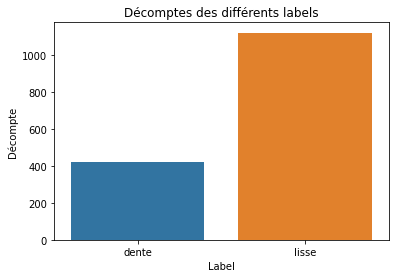

In [243]:
################################################ MODELE 1 : BORDS ##############################################

## CHOIX DE LA FEATURE :
label_names = label_names1 # Le 2ème élement du tableau sera celui converti en "1", le premier sera converti en 0
feature = "bord"



# Récupération des données préparées

def get_images(filename, feature): # Retourne un tableau d'images labellisées seulement selon la feature voulue

  df=pd.read_csv(filename)
  images = []
  labels = []

  for i in range(len(df[feature])):
    path=df["img_path"][i]

    image=cv2.imread("Projet-deep-learning-2022/"+path)
    image=cv2.resize(image,(150,150))
    images.append(image)


    ########## On convertit la réponse texte en valeur numérique
    if df[feature][i]==label_names[1]:
      label = 1
    else:
      label = 0
    
    labels.append(label)

    
  return images,labels



images, labels= get_images(path_train_data, feature)


data_train_labeled=pd.read_csv(path_train_data)
seaborn.countplot(x=data_train_labeled[feature])
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

### Affichage

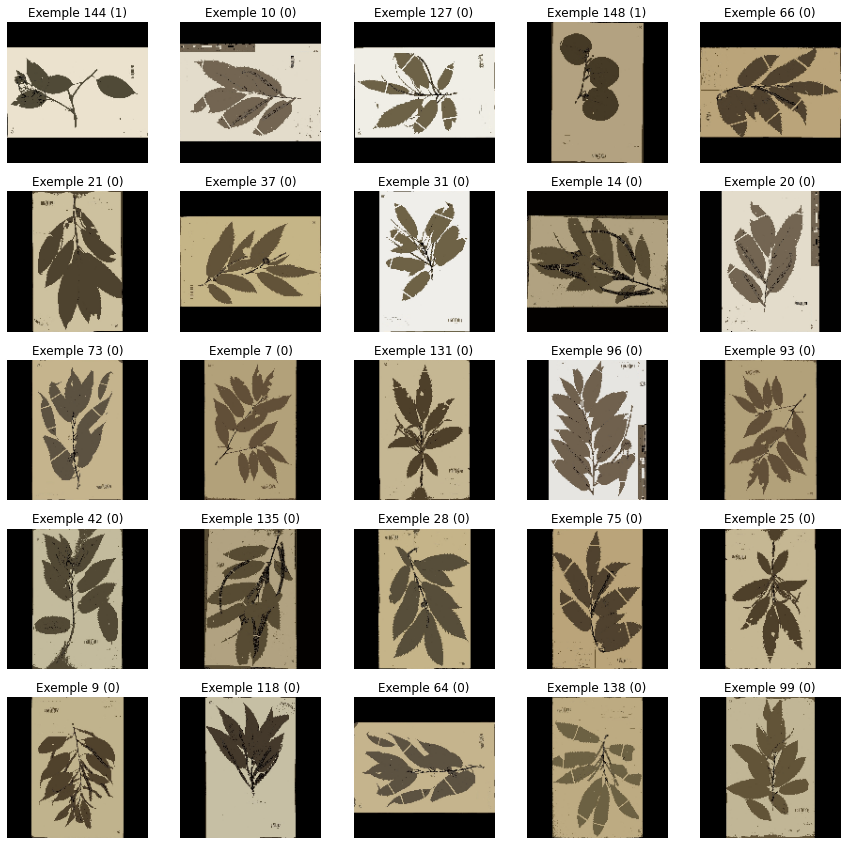

In [244]:
## Affichage des images originales

f, ax = plt.subplots(5, 5, figsize=(15, 15))
random_indexes = np.random.choice(images[0].shape[0], size=(5, 5), replace=False)

for i in range(5):
  for j in range(5):
    img_index = random_indexes[i, j]
    image = images[img_index]
    label = labels[img_index]

    ax[i, j].imshow(image)
    ax[i, j].set_title(f"Exemple {img_index} ({label})")
    ax[i, j].axis('off')

### Construction du modèle

#### Version complèxe

In [245]:
################################################ CONSTRUCTION DU MODELE ########################################

## Version COMPLEXE : apprentissage long et donne des résultats similaires à la version simple

conv2d_params = dict(kernel_size=(3,3), activation="relu", kernel_initializer="orthogonal", padding="same")
dense_params = dict(activation="relu", kernel_initializer="orthogonal")

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(200, 
                              input_shape=(150, 150, 3),
                              **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.MaxPool2D(2, 2, padding="same"))
model.add(keras.layers.Conv2D(200, **conv2d_params))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(200, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(100, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(50, **dense_params))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(11,
                      activation="softmax",
                      kernel_initializer="orthogonal"))

model.compile(optimizer=tf.keras.optimizers.Adam(
              learning_rate=0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#model.summary()

#### version simple

In [269]:
## Version SIMPLE

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(nodes,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model.add(keras.layers.MaxPool2D(3,3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(nodes, activation="softmax"))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#model.summary()

Apprentissage

Epoch 1/40
9/9 [==============================] - 1s 57ms/step - loss: 23.5108 - accuracy: 0.6058 - val_loss: 9.0801 - val_accuracy: 0.5931
Epoch 2/40
9/9 [==============================] - 0s 31ms/step - loss: 9.9643 - accuracy: 0.6605 - val_loss: 8.0538 - val_accuracy: 0.6039
Epoch 3/40
9/9 [==============================] - 0s 28ms/step - loss: 6.2051 - accuracy: 0.7106 - val_loss: 12.8423 - val_accuracy: 0.4286
Epoch 4/40
9/9 [==============================] - 0s 31ms/step - loss: 6.7449 - accuracy: 0.7004 - val_loss: 7.7589 - val_accuracy: 0.6061
Epoch 5/40
9/9 [==============================] - 0s 31ms/step - loss: 4.9441 - accuracy: 0.7365 - val_loss: 3.7946 - val_accuracy: 0.7749
Epoch 6/40
9/9 [==============================] - 0s 30ms/step - loss: 3.7527 - accuracy: 0.7764 - val_loss: 4.0819 - val_accuracy: 0.7468
Epoch 7/40
9/9 [==============================] - 0s 32ms/step - loss: 2.5426 - accuracy: 0.7987 - val_loss: 4.2549 - val_accuracy: 0.7294
Epoch 8/40
9/9 [=========

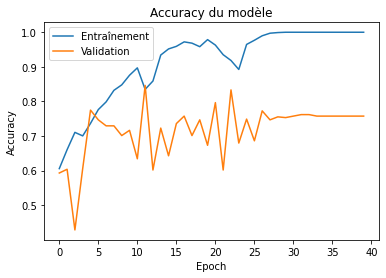

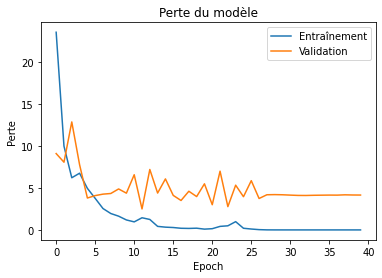

In [270]:
################################################ APPRENTISSAGE ########################################

# Apprentissage du modèle
images=np.array(images)
labels=np.array(labels)


training = model.fit(images, labels, epochs=ep+10, batch_size=128, validation_split=0.30)


# Visualisation des métriques d'entrainement
def plot_metrics(history) -> None:
  plt.plot(training.history["accuracy"])
  plt.plot(training.history["val_accuracy"])
  plt.title("Accuracy du modèle")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper left")
  plt.show()

  plt.plot(training.history["loss"])
  plt.plot(training.history["val_loss"])
  plt.title("Perte du modèle")
  plt.ylabel("Perte")
  plt.xlabel("Epoch")
  plt.legend(["Entraînement", "Validation"], loc="upper right")
  plt.show()


plot_metrics(training.history)

#### Evaluation du modèle

In [271]:
## Evaluation du modèle
test_images, test_labels = get_images(path_test_data, feature)
model.evaluate(np.array(test_images), np.array(test_labels), verbose=1)

4/4 [==============================] - 0s 6ms/step - loss: 4.5316 - accuracy: 0.7091


[4.531645774841309, 0.7090908885002136]

#### Analise des erreurs

4/4 [==============================] - 0s 4ms/step


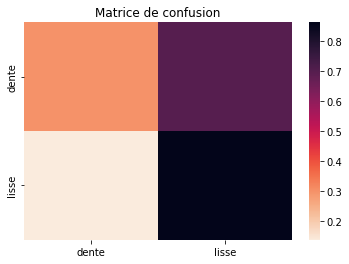

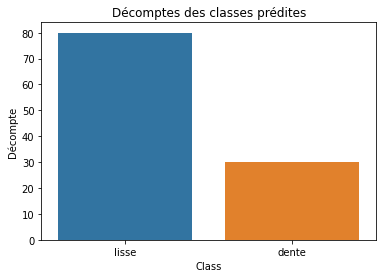

In [272]:
## Analyse des erreurs

def analyze_preds(preds, labels, label_names):
  confusion_matrix = sklearn.metrics.confusion_matrix(preds,
                                                      labels,
                                                      normalize="true")
  seaborn.heatmap(confusion_matrix,
                  cmap="rocket_r",
                  xticklabels=label_names,
                  yticklabels=label_names)
  plt.title("Matrice de confusion")
  plt.show()

  seaborn.countplot(x=list(map(lambda x: label_names[x], preds)))
  plt.title("Décomptes des classes prédites")
  plt.ylabel("Décompte")
  plt.xlabel("Class")
  plt.show()


test_pred = np.argmax(model.predict(np.array(test_images)), axis=-1)
analyze_preds(test_pred, test_labels, label_names1)

Prédiction : 1, classe réelle : 0


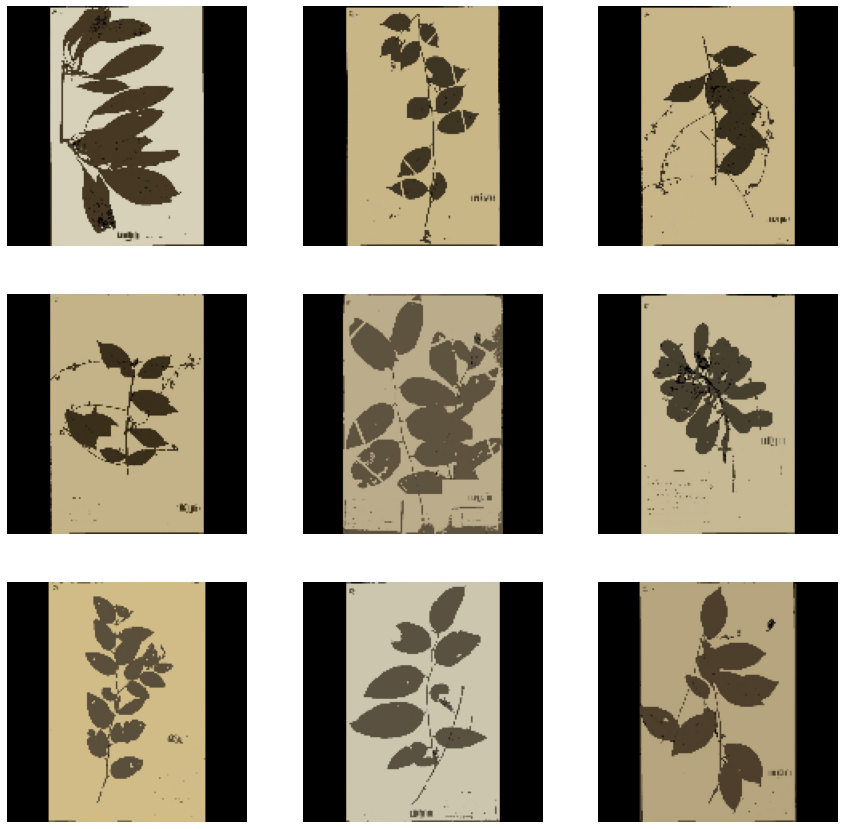

In [273]:
def plot_mistakes(predicted_class: str, true_class: str) -> None:
  print(f"Prédiction : {predicted_class}, classe réelle : {true_class}")
  mistakes=[]

  for index, image in enumerate(test_images):
    if (test_pred[index] == predicted_class) and (test_labels[index] == true_class):
      mistakes.append(image)
  

  random_indexes = np.random.choice(len(mistakes),
                                       size=min(len(mistakes), 9),
                                       replace=False)
  grid_indexes = itertools.product(range(3), repeat=2)

  _, ax = plt.subplots(3, 3, figsize=(15, 15))
  for img_index, (i, j) in zip(random_indexes, grid_indexes):
    ax[i, j].imshow(mistakes[img_index])
    ax[i, j].axis("off")
  plt.show()
  

# On plot quelques unes des images prédites lisses (=1) alors qu'elles sont dentées (=0)
plot_mistakes(1, 0)

#                                                      MODELE 2 : Phyllotaxie

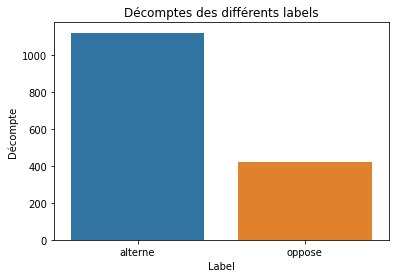

In [251]:
################################################ MODELE 2 : Phyllotaxie ##############################################

## CHOIX DE LA FEATURE :
label_names = label_names2
feature = "phyllotaxie"


images, labels= get_images(path_train_data, feature)

seaborn.countplot(x=data_train_labeled[feature])
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

#### version simple

In [252]:
################################################ CONSTRUCTION DU MODELE ########################################


## Modèle version SIMPLE

model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(nodes+10,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model2.add(keras.layers.MaxPool2D(3,3))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(nodes+10, activation="softmax"))
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#model2.summary()

#### Apprentissage

Epoch 1/35
9/9 [==============================] - 1s 61ms/step - loss: 51.9223 - accuracy: 0.5538 - val_loss: 13.1594 - val_accuracy: 0.6169
Epoch 2/35
9/9 [==============================] - 0s 37ms/step - loss: 8.2658 - accuracy: 0.7254 - val_loss: 14.1884 - val_accuracy: 0.4675
Epoch 3/35
9/9 [==============================] - 0s 38ms/step - loss: 6.3692 - accuracy: 0.7690 - val_loss: 15.6387 - val_accuracy: 0.5498
Epoch 4/35
9/9 [==============================] - 0s 37ms/step - loss: 4.6167 - accuracy: 0.8033 - val_loss: 14.9821 - val_accuracy: 0.4654
Epoch 5/35
9/9 [==============================] - 0s 38ms/step - loss: 3.9697 - accuracy: 0.8228 - val_loss: 18.0429 - val_accuracy: 0.6299
Epoch 6/35
9/9 [==============================] - 0s 38ms/step - loss: 2.9303 - accuracy: 0.8525 - val_loss: 18.9027 - val_accuracy: 0.6623
Epoch 7/35
9/9 [==============================] - 0s 37ms/step - loss: 3.3207 - accuracy: 0.8330 - val_loss: 14.2669 - val_accuracy: 0.5866
Epoch 8/35
9/9 [===

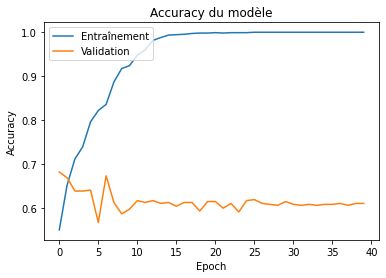

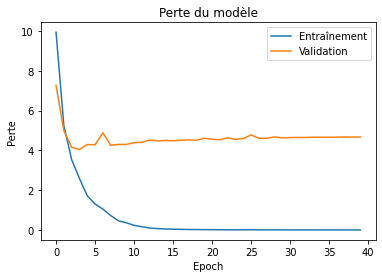

In [253]:
################################################ APPRENTISSAGE ########################################

# Apprentissage du modèle
images=np.array(images)
labels=np.array(labels)


training2 = model2.fit(images, labels, epochs=ep+5, batch_size=128, validation_split=0.30)


# Visualisation des métriques d'entrainement
plot_metrics(training2.history)

#### Evalutation

In [254]:
## Evaluation du modèle
test_images2, test_labels2 = get_images(path_test_data, feature)
model2.evaluate(np.array(test_images2), np.array(test_labels2), verbose=1)

4/4 [==============================] - 0s 6ms/step - loss: 15.0727 - accuracy: 0.6818


[15.072741508483887, 0.6818181872367859]

#### Analise

4/4 [==============================] - 0s 4ms/step


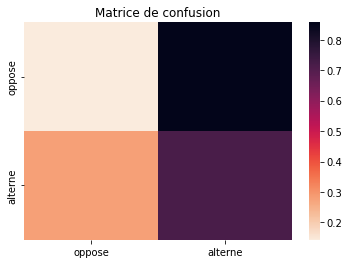

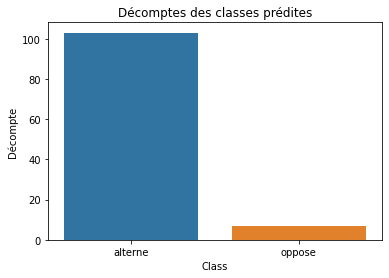

In [255]:
## Analyse des erreurs

test_pred2 = np.argmax(model2.predict(np.array(test_images2)), axis=-1)
analyze_preds(test_pred2, test_labels2, label_names2)

#                                                      MODELE 3 : Type de feuille

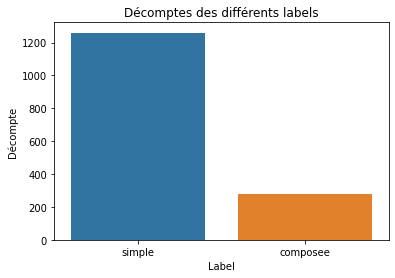

In [256]:
################################################ MODELE 3 : Type de feuille ##############################################

## CHOIX DE LA FEATURE :
label_names = label_names3
feature = "type_feuille"



images, labels= get_images(path_train_data, feature)

seaborn.countplot(x=data_train_labeled[feature])
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

#### Version simple

In [289]:
################################################ CONSTRUCTION DU MODELE ########################################


## Modèle version SIMPLE

model3 = keras.models.Sequential()
model3.add(keras.layers.Conv2D(nodes+5,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model3.add(keras.layers.MaxPool2D(3,3))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(nodes+5, activation="softmax"))
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#model3.summary()

Epoch 1/35
9/9 [==============================] - 1s 58ms/step - loss: 21.4864 - accuracy: 0.6039 - val_loss: 5.4757 - val_accuracy: 0.8052
Epoch 2/35
9/9 [==============================] - 0s 32ms/step - loss: 12.6426 - accuracy: 0.6763 - val_loss: 4.3502 - val_accuracy: 0.8355
Epoch 3/35
9/9 [==============================] - 0s 32ms/step - loss: 11.5842 - accuracy: 0.6596 - val_loss: 12.6291 - val_accuracy: 0.5325
Epoch 4/35
9/9 [==============================] - 0s 32ms/step - loss: 7.4033 - accuracy: 0.7041 - val_loss: 4.6266 - val_accuracy: 0.7424
Epoch 5/35
9/9 [==============================] - 0s 33ms/step - loss: 5.8736 - accuracy: 0.7245 - val_loss: 7.5033 - val_accuracy: 0.6169
Epoch 6/35
9/9 [==============================] - 0s 33ms/step - loss: 5.2093 - accuracy: 0.7393 - val_loss: 3.1279 - val_accuracy: 0.7922
Epoch 7/35
9/9 [==============================] - 0s 32ms/step - loss: 3.5992 - accuracy: 0.7718 - val_loss: 3.0375 - val_accuracy: 0.8009
Epoch 8/35
9/9 [=======

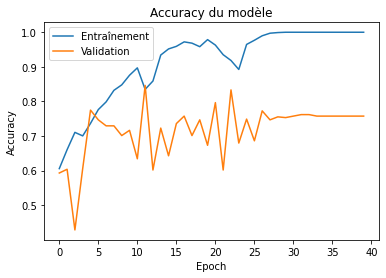

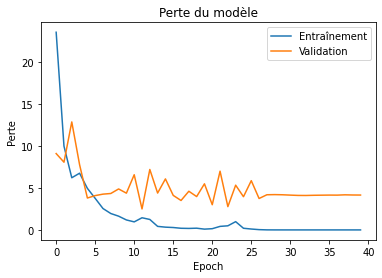

In [290]:
################################################ APPRENTISSAGE ########################################

# Apprentissage du modèle
images=np.array(images)
labels=np.array(labels)


training3 = model3.fit(images, labels, epochs=ep+5, batch_size=128, validation_split=0.30)


# Visualisation des métriques d'entrainement
plot_metrics(training3.history)

#### Evaluation

In [291]:
## Evaluation du modèle
test_images3, test_labels3 = get_images(path_test_data, feature)
model3.evaluate(np.array(test_images3), np.array(test_labels3), verbose=1)

4/4 [==============================] - 0s 6ms/step - loss: 3.5493 - accuracy: 0.7364


[3.54927396774292, 0.7363636493682861]

#### Analise

4/4 [==============================] - 0s 5ms/step


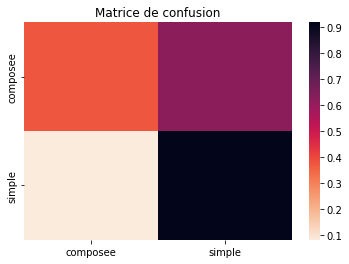

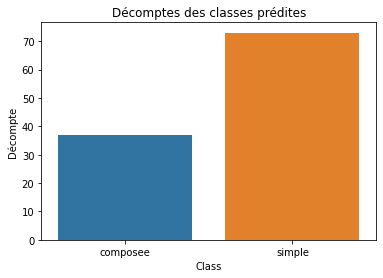

In [292]:
## Analyse des erreurs

test_pred3 = np.argmax(model3.predict(np.array(test_images3)), axis=-1)
analyze_preds(test_pred3, test_labels3, label_names3)

  #  MODELE 4 : Ligneux

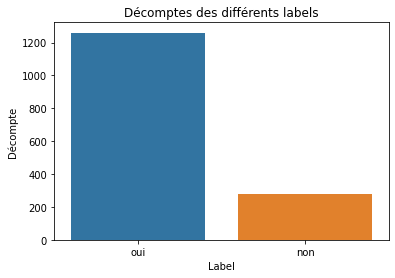

In [261]:
################################################ MODELE 4 : Feuille ligneuse ##############################################

## CHOIX DE LA FEATURE :
label_names = label_names4
feature = "ligneux"



images, labels= get_images(path_train_data, feature)

seaborn.countplot(x=data_train_labeled[feature])
plt.title("Décomptes des différents labels")
plt.ylabel("Décompte")
plt.xlabel("Label")
plt.show()

#### version simple

In [262]:
################################################ CONSTRUCTION DU MODELE ########################################


## Modèle version SIMPLE

model4 = keras.models.Sequential()
model4.add(keras.layers.Conv2D(nodes,
                              kernel_size=(3, 3),
                              activation="relu",
                              input_shape=(150, 150, 3)))
model4.add(keras.layers.MaxPool2D(3,3))
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(nodes, activation="softmax"))
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#model4.summary()

#### Apprentissage

Epoch 1/40
9/9 [==============================] - 1s 50ms/step - loss: 57.5099 - accuracy: 0.5937 - val_loss: 9.2985 - val_accuracy: 0.6926
Epoch 2/40
9/9 [==============================] - 0s 28ms/step - loss: 15.0091 - accuracy: 0.6660 - val_loss: 6.6228 - val_accuracy: 0.7597
Epoch 3/40
9/9 [==============================] - 0s 29ms/step - loss: 13.1300 - accuracy: 0.6744 - val_loss: 5.2675 - val_accuracy: 0.7792
Epoch 4/40
9/9 [==============================] - 0s 28ms/step - loss: 11.0778 - accuracy: 0.6846 - val_loss: 5.3023 - val_accuracy: 0.8723
Epoch 5/40
9/9 [==============================] - 0s 28ms/step - loss: 12.3481 - accuracy: 0.7282 - val_loss: 6.2114 - val_accuracy: 0.7229
Epoch 6/40
9/9 [==============================] - 0s 28ms/step - loss: 6.9943 - accuracy: 0.7254 - val_loss: 7.2661 - val_accuracy: 0.7056
Epoch 7/40
9/9 [==============================] - 0s 28ms/step - loss: 5.5905 - accuracy: 0.7542 - val_loss: 7.9754 - val_accuracy: 0.6645
Epoch 8/40
9/9 [======

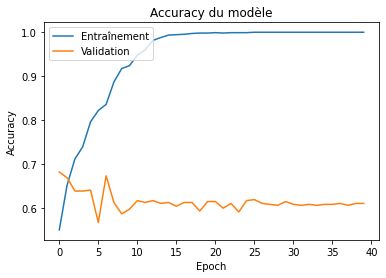

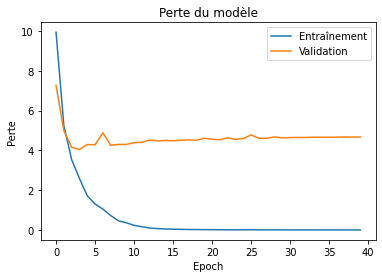

In [263]:
################################################ APPRENTISSAGE ########################################

# Apprentissage du modèle
images=np.array(images)
labels=np.array(labels)


training4 = model4.fit(images, labels, epochs=ep+10, batch_size=128, validation_split=0.30)


# Visualisation des métriques d'entrainement
plot_metrics(training4.history)

#### Evaluation

In [264]:
## Evaluation du modèle
test_images4, test_labels4 = get_images(path_test_data, feature)
model4.evaluate(np.array(test_images4), np.array(test_labels4), verbose=1)

4/4 [==============================] - 0s 7ms/step - loss: 8.4233 - accuracy: 0.6818


[8.4232816696167, 0.6818181872367859]

#### Analise

4/4 [==============================] - 0s 3ms/step


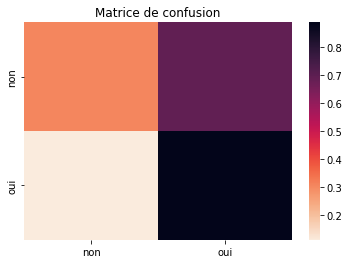

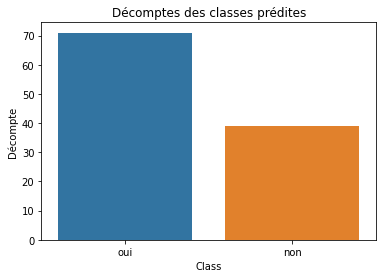

In [265]:
## Analyse des erreurs
test_pred4 = np.argmax(model4.predict(np.array(test_images4)), axis=-1)
analyze_preds(test_pred4, test_labels4, label_names4)

# CONCLUSION des performances

In [293]:
print("Précision du modèle Bords :")
model.evaluate(np.array(test_images), np.array(test_labels), verbose=1)


print("\nPrécision du modèle Phyllotaxie :")
model2.evaluate(np.array(test_images2), np.array(test_labels2), verbose=1)


print("\nPrécision du modèle Type de feuille :")
model3.evaluate(np.array(test_images3), np.array(test_labels3), verbose=1)


print("\nPrécision du modèle Ligneux :")
model4.evaluate(np.array(test_images4), np.array(test_labels4), verbose=1)

Précision du modèle Bords :
4/4 [==============================] - 0s 5ms/step - loss: 4.5316 - accuracy: 0.7091

Précision du modèle Phyllotaxie :
4/4 [==============================] - 0s 6ms/step - loss: 15.0727 - accuracy: 0.6818

Précision du modèle Type de feuille :
4/4 [==============================] - 0s 5ms/step - loss: 3.5493 - accuracy: 0.7364

Précision du modèle Ligneux :
4/4 [==============================] - 0s 5ms/step - loss: 8.4233 - accuracy: 0.6818


[8.4232816696167, 0.6818181872367859]

## Matrices de confusion

Matrice de confusion du modèle Bords


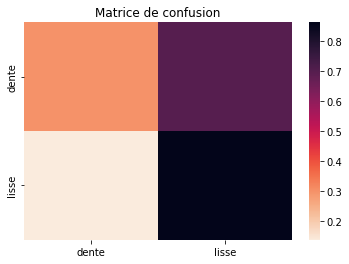

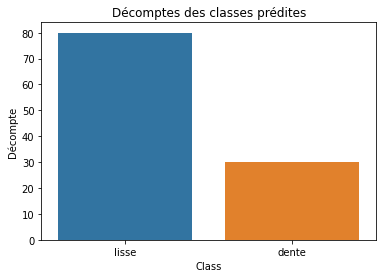


Matrice de confusion du modèle Phyllotaxie


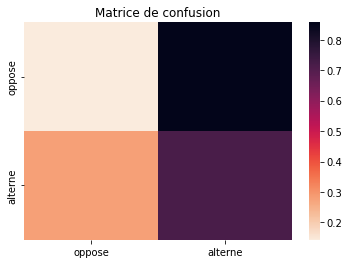

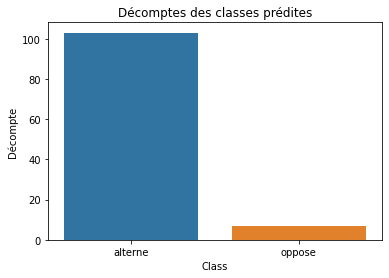


Matrice de confusion du modèle Type de feuille


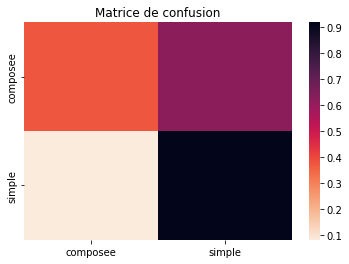

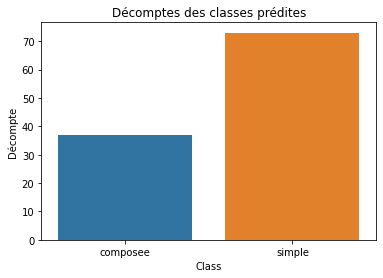


Matrice de confusion du modèle Ligneux


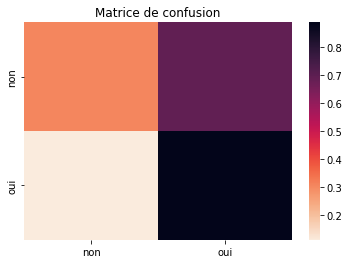

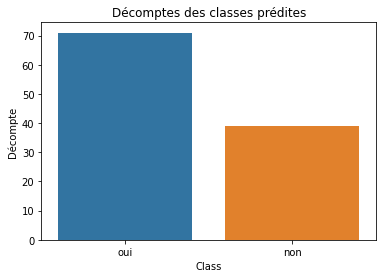

In [294]:
##### Résumé des matrices de confusion

print("Matrice de confusion du modèle Bords")
analyze_preds(test_pred, test_labels, label_names1)

print("\nMatrice de confusion du modèle Phyllotaxie")
analyze_preds(test_pred2, test_labels2, label_names2)

print("\nMatrice de confusion du modèle Type de feuille")
analyze_preds(test_pred3, test_labels3, label_names3)

print("\nMatrice de confusion du modèle Ligneux")
analyze_preds(test_pred4, test_labels4, label_names4)

# Regroupement des features

In [295]:
###################################################################### REGROUPEMENT DES FEATURES ########################################################

correct_preds = [] # Liste des situations où les 4 features prédites sont correctes, et permettent donc d'identifier la bonne plante

for bord, phyllotaxie, type_feuille, ligneux, test1, test2, test3, test4 in zip(test_pred, test_pred2, test_pred3, test_pred4, test_labels, test_labels2, test_labels3, test_labels4):
  if bord == test1 and phyllotaxie == test2 and type_feuille == test3 and ligneux == test4:
    correct_preds.append([bord, phyllotaxie, type_feuille, ligneux])



print("Précision de l'identification d'espèces: " + str(len(correct_preds)/len(test_pred)) )

Précision de l'identification d'espèces: 0.3
